In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import feature_engineering as fe

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.layers import Conv1D, Conv2D, MaxPooling2D
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import csv
import collections
from scipy.stats import zscore
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

from numpy.random import seed
seed(2020)

tf.random.set_seed(2020)

Using TensorFlow backend.


In [2]:
HargaSaham = pd.read_csv("BBNI 2003_2019 bersih.csv")
HargaSaham.head()

,Open,High,Low,Close,Volume
0,1232.400024,1327.199951,1232.400024,1232.400024,426687
1,1232.400024,1303.500000,1232.400024,1303.500000,159810
2,1303.500000,1303.500000,1232.400024,1232.400024,365506
3,1232.400024,1256.099976,1232.400024,1232.400024,71730
4,1232.400024,1256.099976,1232.400024,1232.400024,313290


## Feature Engineering

In [3]:
intervals = range(6,16)
def feature_engineering(HargaSaham, intervals):
    #momentum
    fe.get_rsi(HargaSaham, intervals)
    fe.get_williamR(HargaSaham, intervals) #fillna
    fe.get_cmo(HargaSaham, intervals)
    fe.get_roc(HargaSaham, intervals)
    fe.get_cmf(HargaSaham, intervals)
    
    #trend
    fe.get_cci(HargaSaham, intervals)
    fe.get_adx(HargaSaham, intervals) #take 29 data

    fe.get_sma(HargaSaham, intervals)
    fe.get_ema(HargaSaham, intervals)
    fe.get_tema(HargaSaham, intervals) #take 3*max(interval) - 2 data

In [4]:
feature_engineering(HargaSaham, intervals)

/home/rien/Projects/cnn_stock/feature_engineering.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'rsi_{period}'][1:] = res
/home/rien/Projects/cnn_stock/feature_engineering.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'rsi_{period}'][1:] = res
/home/rien/Projects/cnn_stock/feature_engineering.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'rsi_{period}'][1:] = res
/home/rien/Projects/cnn_stock/feature_en

In [5]:
#Cek apakah ada yang bernilai NaN
HargaSaham[43:].isnull().sum().sum()

0

In [6]:
HargaSaham = HargaSaham[43:]
HargaSaham.shape

(3596, 105)

Data dinormalisasi menjadi [0,1]

In [7]:
HargaSaham = HargaSaham.drop(columns = ['Open', 'High', 'Low', 'Volume'])

scaler = MinMaxScaler(feature_range=(0,1))
HargaSaham = scaler.fit_transform(HargaSaham)
HargaSaham.shape

y_close = HargaSaham[:,0]
HargaSaham = HargaSaham[:,1:]

HargaSaham.shape


(3596, 100)

Pemisahan data menjadi data test dan data train dan pengubahan data menjadi gambar

In [8]:
ntrain = 3000   
                
train = HargaSaham[0:ntrain]
test  = HargaSaham[ntrain:len(HargaSaham)]

y_close_train = y_close[0:ntrain]
y_close_test  = y_close[ntrain:len(y_close)]

def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

train_img = reshape_as_image(train,10,10)

train_img = np.stack((train_img,) * 1, axis=-1)
train_img.shape

test_img = reshape_as_image(test, 10,10)
test_img = np.stack((test_img,) * 1, axis=-1)
test_img.shape

(596, 10, 10, 1)

Hyperparameters CNN

In [9]:
nfilters = 2
kernel_size = (3,3)
strides = (1,1)
padding = 'valid'
activation = 'relu'
pool_size = (2,2)
neuron = 7

Pembangunan model CNN

In [10]:
cnn = Sequential()
cnn.add(Conv2D(nfilters, kernel_size = kernel_size, strides = strides,  padding = padding, 
               activation = activation, input_shape = (10,10,1)))
cnn.add(MaxPooling2D(pool_size = pool_size))

cnn.add(Flatten())
cnn.add(Dense(neuron, activation="relu"))
 
cnn.add(Dense(1, activation="relu"))
cnn.summary()
    
cnn.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1, patience=2, verbose=2, mode='auto') 
checkpointer = ModelCheckpoint(filepath=f"best.hdf5", verbose=0, save_best_only = True) 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 8, 2)           20        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 2)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


Training model

In [11]:
tic = datetime.now()
epochs = 300
cnn.fit(train_img,y_close_train,validation_split=0.2,callbacks=[checkpointer],verbose=0,epochs = epochs)

toc = datetime.now()

print("Waktu yang diperlukan untuk menyelesaikan iterasi: ", toc-tic)

Waktu yang diperlukan untuk menyelesaikan iterasi:  0:01:26.538295


Prediksi data test

In [12]:
cnn.load_weights(f'best.hdf5')

pred = cnn.predict(test_img)
print("Shape: {}".format(pred.shape))
print(pred[0])

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(y_close_test, pred))
print("Final score (RMSE): {}".format(score))

Shape: (596, 1)
[0.6563555]
Final score (RMSE): 0.013037858055055423


Plotting hasil prediksi

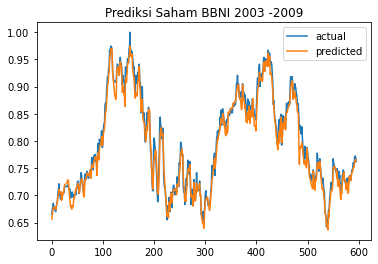

In [13]:
plt.title("Prediksi Saham BBNI 2003 -2009")
plt.plot(y_close_test, label = 'actual')
plt.plot(pred,   label = 'predicted')
plt.savefig("./predicted.png")
plt.legend()
plt.show()